In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import ListedColormap
import seaborn as sns
from cycler import cycler
from IPython.display import display
import datetime
import warnings
from colorama import Fore, Style
import gc
import pickle

from sklearn.model_selection import StratifiedKFold
from sklearn.calibration import CalibrationDisplay
import lightgbm
from catboost import Pool, CatBoostClassifier
from sklearn.preprocessing import LabelEncoder
import catboost
from utils import get_data, amex_metric
import ipywidgets


plt.rcParams['axes.facecolor'] = '#0057b8' # blue
plt.rcParams['axes.prop_cycle'] = cycler(color=['#ffd700'] +
                                         plt.rcParams['axes.prop_cycle'].by_key()['color'][1:])
plt.rcParams['text.color'] = 'w'

In [2]:
CFG = {
    'num_folds': 5,

    'catboost': {
        'depth': 6,
        'iterations': 4000,
        'learning_rate': 0.04,
    },

    'seed': 777
}

In [3]:
train_data, target, cat_features = get_data('data/train_data.ftr', train=True)

In [6]:
model = CatBoostClassifier(
    depth=CFG['catboost']['depth'],
    iterations=2000,
    #learning_rate=CFG['catboost']['learning_rate'],
    custom_metric='AUC',
    random_seed=CFG['seed'],
    thread_count=6,
    early_stopping_rounds=300
)
model.fit(Pool(train_data, target, cat_features=cat_features), verbose=100)

Learning rate set to 0.074722
0:	learn: 0.6071903	total: 616ms	remaining: 20m 32s
100:	learn: 0.2268170	total: 40.8s	remaining: 12m 47s
200:	learn: 0.2199795	total: 1m 19s	remaining: 11m 50s
300:	learn: 0.2155830	total: 1m 58s	remaining: 11m 6s
400:	learn: 0.2121664	total: 2m 36s	remaining: 10m 23s
500:	learn: 0.2091462	total: 3m 14s	remaining: 9m 40s
600:	learn: 0.2063563	total: 3m 51s	remaining: 8m 58s
700:	learn: 0.2037634	total: 4m 30s	remaining: 8m 20s
800:	learn: 0.2011724	total: 5m 7s	remaining: 7m 40s
900:	learn: 0.1988236	total: 5m 44s	remaining: 7m
1000:	learn: 0.1965378	total: 6m 21s	remaining: 6m 20s
1100:	learn: 0.1942578	total: 6m 58s	remaining: 5m 41s
1200:	learn: 0.1920314	total: 7m 35s	remaining: 5m 3s
1300:	learn: 0.1899012	total: 8m 12s	remaining: 4m 24s
1400:	learn: 0.1877845	total: 8m 50s	remaining: 3m 46s
1500:	learn: 0.1857469	total: 9m 28s	remaining: 3m 8s
1600:	learn: 0.1837411	total: 10m 6s	remaining: 2m 31s
1700:	learn: 0.1817336	total: 10m 42s	remaining: 1m 

In [7]:
feature_imp = model.get_feature_importance()
bad_cols = [train_data.columns[i] for i in range(len(train_data.columns)) if feature_imp[i] < 0.03]
train_data.drop(bad_cols, axis=1, inplace=True)
cat_features = [x for x in cat_features if x in train_data.columns.tolist()]

with open('models/feature_list.pkl', 'wb') as f:
    pickle.dump([train_data.columns.tolist(), cat_features], f)

In [8]:
score_list = []
kf = StratifiedKFold(n_splits=CFG['num_folds'], random_state=CFG['seed'], shuffle=True)
for fold, (idx_tr, idx_va) in enumerate(kf.split(train_data, target)):
    start_time = datetime.datetime.now()
    X_tr, X_va = train_data.iloc[idx_tr], train_data.iloc[idx_va]
    y_tr, y_va = target.iloc[idx_tr], target.iloc[idx_va]
    
    model = CatBoostClassifier(
        depth=CFG['catboost']['depth'],
        iterations=CFG['catboost']['iterations'],
        learning_rate=CFG['catboost']['learning_rate'],
        eval_metric='AUC',
        random_seed=CFG['seed'],
        thread_count=6,
        early_stopping_rounds=300
    )
    
    model.fit(Pool(X_tr, y_tr, cat_features=cat_features),
              eval_set=Pool(X_va, y_va, cat_features=cat_features),
              verbose=100, plot=True)
    model.save_model(f'models/catboost_{fold}.cbm')

    y_va_pred = model.predict_proba(Pool(X_va, cat_features=cat_features))[:,1]
    score = amex_metric(y_va.values, y_va_pred)
    n_trees = model.best_iteration_
    if n_trees is None: n_trees = model.n_estimators
    print(f"{Fore.GREEN}{Style.BRIGHT}Fold {fold} | {str(datetime.datetime.now() - start_time)[-12:-7]} |"
          f" {n_trees:5} trees |"
          f"                Score = {score:.5f}{Style.RESET_ALL}")
    score_list.append(score)
    
    gc.collect()

print(f"{Fore.RED}{Style.BRIGHT}OOF Score:   {np.mean(score_list):.5f}{Style.RESET_ALL}")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.9264580	best: 0.9264580 (0)	total: 309ms	remaining: 20m 37s
100:	test: 0.9567919	best: 0.9567919 (100)	total: 20.3s	remaining: 13m 4s
200:	test: 0.9588124	best: 0.9588124 (200)	total: 39.4s	remaining: 12m 24s
300:	test: 0.9598048	best: 0.9598048 (300)	total: 58.2s	remaining: 11m 55s
400:	test: 0.9604372	best: 0.9604372 (400)	total: 1m 17s	remaining: 11m 33s
500:	test: 0.9608329	best: 0.9608329 (500)	total: 1m 36s	remaining: 11m 15s
600:	test: 0.9611113	best: 0.9611113 (600)	total: 1m 55s	remaining: 10m 53s
700:	test: 0.9613068	best: 0.9613068 (700)	total: 2m 14s	remaining: 10m 31s
800:	test: 0.9614610	best: 0.9614611 (798)	total: 2m 33s	remaining: 10m 11s
900:	test: 0.9615940	best: 0.9615940 (900)	total: 2m 51s	remaining: 9m 51s
1000:	test: 0.9617086	best: 0.9617086 (1000)	total: 3m 10s	remaining: 9m 31s
1100:	test: 0.9617986	best: 0.9617993 (1098)	total: 3m 29s	remaining: 9m 11s
1200:	test: 0.9618602	best: 0.9618613 (1191)	total: 3m 48s	remaining: 8m 51s
1300:	test: 0.96192

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.9284352	best: 0.9284352 (0)	total: 301ms	remaining: 20m 2s
100:	test: 0.9556223	best: 0.9556223 (100)	total: 20.5s	remaining: 13m 9s
200:	test: 0.9578499	best: 0.9578499 (200)	total: 39.3s	remaining: 12m 21s
300:	test: 0.9588514	best: 0.9588514 (300)	total: 58.2s	remaining: 11m 54s
400:	test: 0.9594878	best: 0.9594878 (400)	total: 1m 16s	remaining: 11m 29s
500:	test: 0.9598610	best: 0.9598610 (500)	total: 1m 35s	remaining: 11m 8s
600:	test: 0.9601436	best: 0.9601436 (600)	total: 1m 54s	remaining: 10m 48s
700:	test: 0.9603137	best: 0.9603137 (700)	total: 2m 13s	remaining: 10m 30s
800:	test: 0.9604563	best: 0.9604563 (800)	total: 2m 33s	remaining: 10m 11s
900:	test: 0.9605526	best: 0.9605526 (900)	total: 2m 51s	remaining: 9m 50s
1000:	test: 0.9606500	best: 0.9606500 (1000)	total: 3m 10s	remaining: 9m 30s
1100:	test: 0.9607181	best: 0.9607181 (1100)	total: 3m 28s	remaining: 9m 10s
1200:	test: 0.9607840	best: 0.9607840 (1200)	total: 3m 47s	remaining: 8m 49s
1300:	test: 0.9608366

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.9308570	best: 0.9308570 (0)	total: 254ms	remaining: 16m 56s
100:	test: 0.9561609	best: 0.9561609 (100)	total: 20.2s	remaining: 13m
200:	test: 0.9584195	best: 0.9584195 (200)	total: 39.6s	remaining: 12m 29s
300:	test: 0.9594759	best: 0.9594759 (300)	total: 59s	remaining: 12m 5s
400:	test: 0.9601933	best: 0.9601933 (400)	total: 1m 17s	remaining: 11m 38s
500:	test: 0.9606297	best: 0.9606297 (500)	total: 1m 36s	remaining: 11m 14s
600:	test: 0.9609410	best: 0.9609410 (600)	total: 1m 55s	remaining: 10m 52s
700:	test: 0.9611592	best: 0.9611594 (698)	total: 2m 13s	remaining: 10m 30s
800:	test: 0.9613409	best: 0.9613419 (799)	total: 2m 32s	remaining: 10m 9s
900:	test: 0.9614749	best: 0.9614749 (900)	total: 2m 51s	remaining: 9m 48s
1000:	test: 0.9616042	best: 0.9616042 (1000)	total: 3m 9s	remaining: 9m 28s
1100:	test: 0.9616985	best: 0.9616985 (1100)	total: 3m 28s	remaining: 9m 8s
1200:	test: 0.9617766	best: 0.9617781 (1198)	total: 3m 46s	remaining: 8m 48s
1300:	test: 0.9618129	best: 

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.9300987	best: 0.9300987 (0)	total: 268ms	remaining: 17m 52s
100:	test: 0.9560406	best: 0.9560406 (100)	total: 20.7s	remaining: 13m 18s
200:	test: 0.9581360	best: 0.9581360 (200)	total: 39.9s	remaining: 12m 33s
300:	test: 0.9591309	best: 0.9591309 (300)	total: 58.9s	remaining: 12m 4s
400:	test: 0.9597413	best: 0.9597413 (400)	total: 1m 17s	remaining: 11m 37s
500:	test: 0.9601202	best: 0.9601202 (500)	total: 1m 36s	remaining: 11m 14s
600:	test: 0.9604003	best: 0.9604003 (600)	total: 1m 55s	remaining: 10m 51s
700:	test: 0.9606030	best: 0.9606030 (700)	total: 2m 14s	remaining: 10m 33s
800:	test: 0.9607615	best: 0.9607615 (800)	total: 2m 33s	remaining: 10m 13s
900:	test: 0.9608812	best: 0.9608812 (900)	total: 2m 52s	remaining: 9m 52s
1000:	test: 0.9609822	best: 0.9609822 (1000)	total: 3m 10s	remaining: 9m 32s
1100:	test: 0.9610514	best: 0.9610514 (1100)	total: 3m 30s	remaining: 9m 14s
1200:	test: 0.9611243	best: 0.9611243 (1200)	total: 3m 49s	remaining: 8m 55s
1300:	test: 0.96116

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.9288983	best: 0.9288983 (0)	total: 302ms	remaining: 20m 6s
100:	test: 0.9552982	best: 0.9552982 (100)	total: 20.3s	remaining: 13m 5s
200:	test: 0.9574110	best: 0.9574110 (200)	total: 39.6s	remaining: 12m 29s
300:	test: 0.9584160	best: 0.9584160 (300)	total: 59.7s	remaining: 12m 14s
400:	test: 0.9590628	best: 0.9590628 (400)	total: 1m 19s	remaining: 11m 50s
500:	test: 0.9594156	best: 0.9594156 (500)	total: 1m 38s	remaining: 11m 25s
600:	test: 0.9596658	best: 0.9596658 (600)	total: 1m 57s	remaining: 11m 3s
700:	test: 0.9598382	best: 0.9598395 (699)	total: 2m 16s	remaining: 10m 42s
800:	test: 0.9599812	best: 0.9599812 (800)	total: 2m 35s	remaining: 10m 21s
900:	test: 0.9600740	best: 0.9600740 (900)	total: 2m 54s	remaining: 10m 1s
1000:	test: 0.9601176	best: 0.9601176 (1000)	total: 3m 12s	remaining: 9m 38s
1100:	test: 0.9601811	best: 0.9601811 (1100)	total: 3m 32s	remaining: 9m 18s
1200:	test: 0.9602264	best: 0.9602264 (1200)	total: 3m 50s	remaining: 8m 58s
1300:	test: 0.9602858

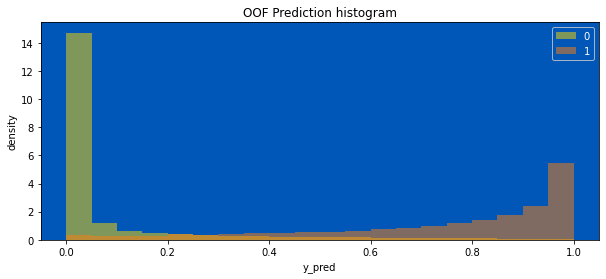

In [9]:
plt.figure(figsize=(10, 4))
plt.hist(y_va_pred[y_va == 0], bins=np.linspace(0, 1, 21),
         alpha=0.5, density=True, label='0')
plt.hist(y_va_pred[y_va == 1], bins=np.linspace(0, 1, 21),
         alpha=0.5, density=True, label='1')
plt.xlabel('y_pred')
plt.ylabel('density')
plt.title('OOF Prediction histogram', color='k')
plt.legend()
plt.show()

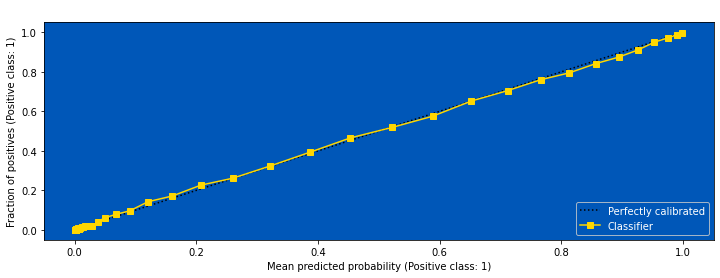

In [10]:
plt.figure(figsize=(12, 4))
CalibrationDisplay.from_predictions(y_va, y_va_pred, n_bins=50, strategy='quantile', ax=plt.gca())
plt.title('Probability calibration')
plt.show()